# Setup
(No need to change anything)

In [ ]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEBUG_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-sa_v46nq
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-sa_v46nq
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit 0825c5eb4196e7ad72d28bcf4e615306b3897490
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [ ]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [ ]:
torch.set_grad_enabled(False)

## Load Model

In [ ]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Loaded pretrained model gpt2-small into HookedTransformer


## Import functions from repo

In [ ]:
!git clone https://github.com/callummcdougall/ARENA_2.0.git

Cloning into 'ARENA_2.0'...
remote: Enumerating objects: 9262, done.
remote: Counting objects: 100% (1976/1976), done.
remote: Compressing objects: 100% (344/344), done.
remote: Total 9262 (delta 1727), reused 1731 (delta 1628), pack-reused 7286
Receiving objects: 100% (9262/9262), 156.79 MiB | 15.30 MiB/s, done.
Resolving deltas: 100% (5620/5620), done.
Updating files: 100% (387/387), done.


In [ ]:
cd ARENA_2.0/chapter1_transformers/exercises/part3_indirect_object_identification

/content/ARENA_2.0/chapter1_transformers/exercises/part3_indirect_object_identification/ARENA_2.0/chapter1_transformers/exercises/part3_indirect_object_identification


In [ ]:
import ioi_circuit_extraction as ioi_circuit_extraction

In [ ]:
from ioi_dataset import IOIDataset

# test

In [ ]:
def remove_batch_dim(
    tensor: Float[torch.Tensor, "1 ..."]
) -> Float[torch.Tensor, "..."]:
    """
    Removes the first dimension of a tensor if it is size 1, otherwise returns the tensor unchanged
    """
    if tensor.shape[0] == 1:
        return tensor.squeeze(0)
    else:
        return tensor

def test_prompt(
    prompt: str,
    answer: str,
    model,
    orig_model,
    prepend_space_to_answer: bool = True,
    print_details: bool = True,
    prepend_bos: bool = True,
    top_k: int = 10,
):
    """
    Function to test whether a model can give the correct answer to a prompt. Intended for exploratory analysis, so it prints things out rather than returning things.

    Works for multi-token answers and multi-token prompts.

    Will always print the ranks of the answer tokens, and if print_details will print the logit and prob for the answer tokens and the top k tokens returned for each answer position.
    """
    if prepend_space_to_answer and not answer.startswith(" "):
        answer = " " + answer
    # GPT-2 often treats the first token weirdly, so lets give it a resting position
    tokens = orig_model.to_tokens(prompt + answer, prepend_bos=prepend_bos)


    prompt_str_tokens = orig_model.to_str_tokens(prompt, prepend_bos=prepend_bos)
    answer_str_tokens = orig_model.to_str_tokens(answer, prepend_bos=False)
    prompt_length = len(prompt_str_tokens)
    answer_length = len(answer_str_tokens)
    if print_details:
        print("Tokenized prompt:", prompt_str_tokens)
        print("Tokenized answer:", answer_str_tokens)

    logits = remove_batch_dim(model(tokens))

    probs = logits.softmax(dim=-1)
    answer_ranks = []
    for index in range(prompt_length, prompt_length + answer_length):
        answer_token = tokens[0, index]
        answer_str_token = answer_str_tokens[index - prompt_length]
        # Offset by 1 because models predict the NEXT token
        token_probs = probs[index - 1]
        sorted_token_probs, sorted_token_values = token_probs.sort(descending=True) # sorted_token_values are the indices; the indices correspond to token num of vocab
        # Janky way to get the index of the token in the sorted list - I couldn't find a better way?
        correct_rank = torch.arange(len(sorted_token_values))[
            (sorted_token_values == answer_token).cpu()
        ].item()
        answer_ranks.append((answer_str_token, correct_rank))
        if print_details:
            # String formatting syntax - the first number gives the number of characters to pad to, the second number gives the number of decimal places.
            # rprint gives rich text printing
            print(
                f"Performance on answer token:\n[b]Rank: {correct_rank: <8} Logit: {logits[index-1, answer_token].item():5.2f} Prob: {token_probs[answer_token].item():6.2%} Token: |{answer_str_token}|[/b]"
            )
            for i in range(top_k):
                print(
                    f"Top {i}th token. Logit: {logits[index-1, sorted_token_values[i]].item():5.2f} Prob: {sorted_token_probs[i].item():6.2%} Token: |{orig_model.to_string(sorted_token_values[i])}|"
                )
    print(f"[b]Ranks of the answer tokens:[/b] {answer_ranks}")

In [ ]:
prompt = "1 2 3 4"
answer = " 5"

prompt_str_tokens = model.to_str_tokens(prompt, prepend_bos=True)
answer_str_tokens = model.to_str_tokens(answer, prepend_bos=False)
prompt_length = len(prompt_str_tokens)
answer_length = len(answer_str_tokens)

print("Tokenized prompt:", prompt_str_tokens)
print("Tokenized answer:", answer_str_tokens)

Tokenized prompt: ['<|endoftext|>', '1', ' 2', ' 3', ' 4']
Tokenized answer: [' 5']


In [ ]:
model.reset_hooks(including_permanent=True)
# tokens = model.to_tokens(prompt)
tokens = model.to_tokens(prompt + answer, prepend_bos=True)

In [ ]:
logits = model(tokens)

In [ ]:
logits.size()

torch.Size([1, 6, 50257])

In [ ]:
logits = logits.squeeze(0)
logits.size()

torch.Size([6, 50257])

In [ ]:
top_k = 6

probs = logits.softmax(dim=-1)
answer_ranks = []
for index in range(prompt_length, prompt_length + answer_length):
    answer_token = tokens[0, index]
    answer_str_token = answer_str_tokens[index - prompt_length]
    # Offset by 1 because models predict the NEXT token
    token_probs = probs[index - 1]
    sorted_token_probs, sorted_token_values = token_probs.sort(descending=True) # sorted_token_values are the indices; the indices correspond to token num of vocab
    # Janky way to get the index of the token in the sorted list - I couldn't find a better way?
    correct_rank = torch.arange(len(sorted_token_values))[
        (sorted_token_values == answer_token).cpu()
    ].item()
    answer_ranks.append((answer_str_token, correct_rank))

    # String formatting syntax - the first number gives the number of characters to pad to, the second number gives the number of decimal places.
    # rprint gives rich text printing
    print(
        f"Performance on answer token:\n[b]Rank: {correct_rank: <8} Logit: {logits[index-1, answer_token].item():5.2f} Prob: {token_probs[answer_token].item():6.2%} Token: |{answer_str_token}|[/b]"
    )
    for i in range(top_k):
        print(
            f"Top {i}th token. Logit: {logits[index-1, sorted_token_values[i]].item():5.2f} Prob: {sorted_token_probs[i].item():6.2%} Token: |{model.to_string(sorted_token_values[i])}|"
        )
print(f"[b]Ranks of the answer tokens:[/b] {answer_ranks}")

Performance on answer token:
[b]Rank: 0        Logit: 18.76 Prob: 96.18% Token: | 5|[/b]
Top 0th token. Logit: 18.76 Prob: 96.18% Token: | 5|
Top 1th token. Logit: 13.27 Prob:  0.40% Token: | Next|
Top 2th token. Logit: 13.01 Prob:  0.30% Token: |
|
Top 3th token. Logit: 12.87 Prob:  0.27% Token: | >|
Top 4th token. Logit: 12.04 Prob:  0.12% Token: | 4|
Top 5th token. Logit: 11.88 Prob:  0.10% Token: | 50|
[b]Ranks of the answer tokens:[/b] [(' 5', 0)]


# Generate dataset with multiple prompts

In [ ]:
class Dataset:
    def __init__(self, prompts, pos_dict, tokenizer, S1_is_first=False):
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.N = len(prompts)
        self.max_len = max(
            [
                len(self.tokenizer(prompt["text"]).input_ids)
                for prompt in self.prompts
            ]
        )
        # all_ids = [prompt["TEMPLATE_IDX"] for prompt in self.ioi_prompts]
        all_ids = [0 for prompt in self.prompts] # only 1 template
        all_ids_ar = np.array(all_ids)
        self.groups = []
        for id in list(set(all_ids)):
            self.groups.append(np.where(all_ids_ar == id)[0])

        texts = [ prompt["text"] for prompt in self.prompts ]
        self.toks = torch.Tensor(self.tokenizer(texts, padding=True).input_ids).type(
            torch.int
        )
        self.corr_tokenIDs = [
            self.tokenizer.encode(" " + prompt["corr"])[0] for prompt in self.prompts
        ]
        self.incorr_tokenIDs = [
            self.tokenizer.encode(" " + prompt["incorr"])[0] for prompt in self.prompts
        ]

        # word_idx: for every prompt, find the token index of each target token and "end"
        # word_idx is a tensor with an element for each prompt. The element is the targ token's ind at that prompt
        self.word_idx = {}
        for targ in [key for key in self.prompts[0].keys() if (key != 'text' and key != 'corr' and key != 'incorr')]:
            targ_lst = []
            for prompt in self.prompts:
                input_text = prompt["text"]
                tokens = model.tokenizer.tokenize(input_text)
                # if S1_is_first and targ == "S1":  # only use this if first token doesn't have space Ġ in front
                #     target_token = prompt[targ]
                # else:
                #     target_token = "Ġ" + prompt[targ]
                # target_index = tokens.index(target_token)
                target_index = pos_dict[targ]
                targ_lst.append(target_index)
            self.word_idx[targ] = torch.tensor(targ_lst)

        targ_lst = []
        for prompt in self.prompts:
            input_text = prompt["text"]
            tokens = self.tokenizer.tokenize(input_text)
            end_token_index = len(tokens) - 1
            targ_lst.append(end_token_index)
        self.word_idx["end"] = torch.tensor(targ_lst)

    def __len__(self):
        return self.N

In [ ]:
pos_dict = {
    'S1': 0,
    'S2': 1,
    'S3': 2,
    'S4': 3,
}

In [ ]:
def generate_prompts_list(x ,y):
    prompts_list = []
    for i in range(x, y):
        prompt_dict = {
            'S1': str(i),
            'S2': str(i+1),
            'S3': str(i+2),
            'S4': str(i+3),
            'corr': str(i+4),
            'incorr': str(i+3),
            'text': f"{i} {i+1} {i+2} {i+3}"
        }
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(1, 101)
dataset = Dataset(prompts_list, pos_dict, model.tokenizer, S1_is_first=True)

In [ ]:
import random

def generate_prompts_list_corr(x ,y):
    prompts_list = []
    for i in range(x, y):
        r1 = random.randint(1, 100)
        r2 = random.randint(1, 100)
        while True:
            r3 = random.randint(1, 100)
            r4 = random.randint(1, 100)
            if r4 - 1 != r3:
                break
        prompt_dict = {
            'S1': str(r1),
            'S2': str(r2),
            'S3': str(r3),
            'S4': str(r4),
            'corr': str(i+4),
            'incorr': str(i+3),
            'text': f"{r1} {r2} {r3} {r4}"
        }
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list_2 = generate_prompts_list_corr(1, 101)
# prompts_list_2 = generate_prompts_list_corr(1, 2)
dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer, S1_is_first=True)

In [ ]:
dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer, S1_is_first=True)

# MLP ablation fns

In [ ]:
from typing import Dict, Tuple, List
from jaxtyping import Float, Bool
import torch as t

# lst = [(layer, head) for layer in range(12) for head in range(12)]
lst = [layer for layer in range(12)]
CIRCUIT = {
    "number mover": lst,
    # "number mover 4": lst,
    "number mover 3": lst,
    "number mover 2": lst,
    "number mover 1": lst,
}

SEQ_POS_TO_KEEP = {
    "number mover": "end",
    # "number mover 4": "S4",
    "number mover 3": "S3",
    "number mover 2": "S2",
    "number mover 1": "S1",
}

def logits_to_ave_logit_diff(logits: Float[Tensor, "batch seq d_vocab"], dataset: Dataset, per_prompt=False):
    '''
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    '''

    # Only the final logits are relevant for the answer
    # Get the logits corresponding to the indirect object / subject tokens respectively
    corr_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset.word_idx["end"], dataset.corr_tokenIDs]
    incorr_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset.word_idx["end"], dataset.incorr_tokenIDs]
    # Find logit difference
    answer_logit_diff = corr_logits - incorr_logits
    return answer_logit_diff if per_prompt else answer_logit_diff.mean()

In [ ]:
def compute_means_by_template_MLP(
    means_dataset: Dataset,
    model: HookedTransformer
) -> Float[Tensor, "layer batch seq head_idx d_head"]:
    '''
    Returns the mean of each head's output over the means dataset. This mean is
    computed separately for each group of prompts with the same template (these
    are given by means_dataset.groups).
    '''
    # Cache the outputs of every head
    _, means_cache = model.run_with_cache(
        means_dataset.toks.long(),
        return_type=None,
        # names_filter=lambda name: name.endswith("z"),
    )
    # Create tensor to store means
    n_layers, d_model = model.cfg.n_layers, model.cfg.d_model
    batch, seq_len = len(means_dataset), means_dataset.max_len
    means = t.zeros(size=(n_layers, batch, seq_len, d_model), device=model.cfg.device)

    # Get set of different templates for this data
    for layer in range(n_layers):
        mlp_output_for_this_layer: Float[Tensor, "batch seq d_model"] = means_cache[utils.get_act_name("mlp_out", layer)]
        for template_group in means_dataset.groups:  # here, we only have one group
            mlp_output_for_this_template = mlp_output_for_this_layer[template_group]
            # aggregate all batches
            mlp_output_means_for_this_template = einops.reduce(mlp_output_for_this_template, "batch seq d_model -> seq d_model", "mean")
            means[layer, template_group] = mlp_output_means_for_this_template
            # at layer, each batch ind is tempalte group (a tensor of size seq d_model)
            # is assigned the SAME mean, "mlp_output_means_for_this_template"

    # # Get set of different templates for this data
    # for layer in range(model.cfg.n_layers):
    #     z_for_this_layer: Float[Tensor, "batch seq head d_head"] = means_cache[utils.get_act_name("z", layer)]
    #     for template_group in means_dataset.groups:
    #         z_for_this_template = z_for_this_layer[template_group]
    #         z_means_for_this_template = einops.reduce(z_for_this_template, "batch seq head d_head -> seq head d_head", "mean")
    #         means[layer, template_group] = z_means_for_this_template

    return means

In [ ]:
model.reset_hooks(including_permanent=True)

# Compute the mean of each head's output on the ABC dataset, grouped by template
means = compute_means_by_template_MLP(dataset_2, model)
means.size()

torch.Size([12, 100, 4, 768])

In [ ]:
def get_mlp_outputs_and_posns_to_keep(
    means_dataset: Dataset,
    model: HookedTransformer,
    circuit: Dict[str, List[int]],  # Adjusted to hold list of layers instead of (layer, head) tuples
    seq_pos_to_keep: Dict[str, str],
) -> Dict[int, Bool[Tensor, "batch seq"]]:  # Adjusted the return type to "batch seq"
    '''
    Returns a dictionary mapping layers to a boolean mask giving the indices of the
    MLP output which *shouldn't* be mean-ablated.

    The output of this function will be used for the hook function that does ablation.
    '''
    mlp_outputs_and_posns_to_keep = {}
    batch, seq = len(means_dataset), means_dataset.max_len

    for layer in range(model.cfg.n_layers):
        mask = t.zeros(size=(batch, seq))

        for (mlp_type, layer_list) in circuit.items():
            seq_pos = seq_pos_to_keep[mlp_type]
            indices = means_dataset.word_idx[seq_pos]
            if layer in layer_list:  # Check if the current layer is in the layer list for this mlp_type
                mask[:, indices] = 1

        mlp_outputs_and_posns_to_keep[layer] = mask.bool()

    return mlp_outputs_and_posns_to_keep

In [ ]:
mlp_outputs_and_posns_to_keep = get_mlp_outputs_and_posns_to_keep(dataset_2, model, CIRCUIT, SEQ_POS_TO_KEEP)

In [ ]:
def hook_fn_mask_mlp_out(
    mlp_out: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint,
    mlp_outputs_and_posns_to_keep: Dict[int, Bool[Tensor, "batch seq"]],
    means: Float[Tensor, "layer batch seq d_mlp"],
) -> Float[Tensor, "batch seq d_mlp"]:
    '''
    Hook function which masks the MLP output of a transformer layer.

    mlp_outputs_and_posns_to_keep
        Dict created with the get_mlp_outputs_and_posns_to_keep function. This tells
        us where to mask.

    means
        Tensor of mean MLP output values of the means_dataset over each group of prompts
        with the same template. This tells us what values to mask with.
    '''
    # Get the mask for this layer, adapted for MLP output structure
    mask_for_this_layer = mlp_outputs_and_posns_to_keep[hook.layer()].unsqueeze(-1).to(mlp_out.device)

    # Set MLP output values to the mean where necessary
    mlp_out = t.where(mask_for_this_layer, mlp_out, means[hook.layer()])

    return mlp_out

In [ ]:
# def add_mean_ablation_hook(
#     model: HookedTransformer,
#     means_dataset: Dataset,
#     circuit: Dict[str, List[Tuple[int, int]]] = CIRCUIT,
#     seq_pos_to_keep: Dict[str, str] = SEQ_POS_TO_KEEP,
#     is_permanent: bool = True,
# ) -> HookedTransformer:
#     '''
#     Adds a permanent hook to the model, which ablates according to the circuit and
#     seq_pos_to_keep dictionaries.

#     In other words, when the model is run on ioi_dataset, every head's output will
#     be replaced with the mean over means_dataset for sequences with the same template,
#     except for a subset of heads and sequence positions as specified by the circuit
#     and seq_pos_to_keep dicts.
#     '''

#     model.reset_hooks(including_permanent=True)

#     # Compute the mean of each head's output on the ABC dataset, grouped by template
#     means = compute_means_by_template(means_dataset, model)

#     # Convert this into a boolean map
#     heads_and_posns_to_keep = get_heads_and_posns_to_keep(means_dataset, model, circuit, seq_pos_to_keep)

#     # Get a hook function which will patch in the mean z values for each head, at
#     # all positions which aren't important for the circuit
#     hook_fn = partial(
#         hook_fn_mask_z,
#         heads_and_posns_to_keep=heads_and_posns_to_keep,
#         means=means
#     )

#     # Apply hook
#     model.add_hook(lambda name: name.endswith("z"), hook_fn, is_permanent=is_permanent)

#     return model

In [ ]:
model.reset_hooks(including_permanent=True)
logits_orig, orig_cache = model.run_with_cache(dataset.toks)
orig_score = logits_to_ave_logit_diff(logits_orig, dataset)

In [ ]:
logits_orig.size()

torch.Size([100, 4, 50257])

In [ ]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

# Get a hook function which will patch in the mean MLP output values for each MLP layer, at
# all positions which aren't important for the circuit
hook_fn = partial(
    hook_fn_mask_mlp_out,
    mlp_outputs_and_posns_to_keep = mlp_outputs_and_posns_to_keep,
    means=means
)

# Apply hook
model.add_hook(lambda name: name.endswith("mlp_out"), hook_fn, is_permanent=True)

new_logits = model(dataset.toks)
# new_logits.size()

new_score = logits_to_ave_logit_diff(new_logits, dataset)

print(f"Average logit difference (dataset, using entire model): {orig_score:.4f}")
print(f"Average logit difference (dataset, only using circuit): {new_score:.4f}")
print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")

Average logit difference (dataset, using entire model): 5.8226
Average logit difference (dataset, only using circuit): 5.8226
Average logit difference (circuit / full) %: 100.0000


In [ ]:
def add_mean_ablation_hook_MLP(
    model: HookedTransformer,
    means_dataset: Dataset,
    circuit: Dict[str, List[Tuple[int, int]]] = CIRCUIT,
    seq_pos_to_keep: Dict[str, str] = SEQ_POS_TO_KEEP,
    is_permanent: bool = True,
) -> HookedTransformer:
    '''
    Adds a permanent hook to the model, which ablates according to the circuit and
    seq_pos_to_keep dictionaries.

    In other words, when the model is run on ioi_dataset, every head's output will
    be replaced with the mean over means_dataset for sequences with the same template,
    except for a subset of heads and sequence positions as specified by the circuit
    and seq_pos_to_keep dicts.
    '''

    model.reset_hooks(including_permanent=True)

    # Compute the mean of each head's output on the ABC dataset, grouped by template
    means = compute_means_by_template_MLP(means_dataset, model)

    # Convert this into a boolean map
    mlp_outputs_and_posns_to_keep = get_mlp_outputs_and_posns_to_keep(means_dataset, model, circuit, seq_pos_to_keep)

    # Get a hook function which will patch in the mean z values for each head, at
    # all positions which aren't important for the circuit
    hook_fn = partial(
        hook_fn_mask_mlp_out,
        mlp_outputs_and_posns_to_keep=mlp_outputs_and_posns_to_keep,
        means=means
    )

    # Apply hook
    model.add_hook(lambda name: name.endswith("mlp_out"), hook_fn, is_permanent=True)

    return model

In [ ]:
def mean_ablate_by_lst_MLP(lst, model, orig_score, print_output=True):
    CIRCUIT = {
        "number mover": lst,
        # "number mover 4": lst,
        "number mover 3": lst,
        "number mover 2": lst,
        "number mover 1": lst,
    }

    SEQ_POS_TO_KEEP = {
        "number mover": "end",
        # "number mover 4": "S4",
        "number mover 3": "S3",
        "number mover 2": "S2",
        "number mover 1": "S1",
    }

    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

    # ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

    model = add_mean_ablation_hook_MLP(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
    new_logits = model(dataset.toks)

    # orig_score = logits_to_ave_logit_diff_2(ioi_logits_original, dataset)
    new_score = logits_to_ave_logit_diff(new_logits, dataset)
    if print_output:
        # print(f"Average logit difference (IOI dataset, using entire model): {orig_score:.4f}")
        # print(f"Average logit difference (IOI dataset, only using circuit): {new_score:.4f}")
        print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")
    # return new_score
    return 100 * new_score / orig_score

In [ ]:
lst = [layer for layer in range(12) if layer !=9]
perc_of_orig = mean_ablate_by_lst_MLP(lst, model, orig_score, print_output=False).item()
perc_of_orig

In [ ]:
for i in range(12):
    lst = [layer for layer in range(12) if layer != i]
    perc_of_orig = mean_ablate_by_lst_MLP(lst, model, orig_score, print_output=False).item()
    print(i, perc_of_orig)

In [ ]:
mlp_to_not_ablate = [0, 1, 2, 4, 6, 9, 10, 11]
perc_of_orig = mean_ablate_by_lst_MLP(mlp_to_not_ablate, model, orig_score, print_output=False).item()
print(perc_of_orig)

In [ ]:
mlp_to_not_ablate = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
perc_of_orig = mean_ablate_by_lst_MLP(mlp_to_not_ablate, model, orig_score, print_output=False).item()
print(perc_of_orig)

In [ ]:
mlp_to_not_ablate = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
perc_of_orig = mean_ablate_by_lst_MLP(mlp_to_not_ablate, model, orig_score, print_output=False).item()
print(perc_of_orig)

In [ ]:
mlp_to_not_ablate = [0, 8, 9, 10, 11]
perc_of_orig = mean_ablate_by_lst_MLP(mlp_to_not_ablate, model, orig_score, print_output=False).item()
print(perc_of_orig)

# ablate model and run

In [ ]:
def test_prompt(
    prompt: str,
    answer: str,
    model,  # Can't give type hint due to circular imports
    prepend_space_to_answer: Optional[bool] = True,
    print_details: Optional[bool] = True,
    prepend_bos: Optional[bool] = USE_DEFAULT_VALUE,
    top_k: Optional[int] = 10,
) -> None:
    """Test if the Model Can Give the Correct Answer to a Prompt.

    Intended for exploratory analysis. Prints out the performance on the answer (rank, logit, prob),
    as well as the top k tokens. Works for multi-token prompts and multi-token answers.

    Warning:

    This will print the results (it does not return them).

    Examples:

    >>> from transformer_lens import HookedTransformer, utils
    >>> model = HookedTransformer.from_pretrained("tiny-stories-1M")
    Loaded pretrained model tiny-stories-1M into HookedTransformer

    >>> prompt = "Why did the elephant cross the"
    >>> answer = "road"
    >>> utils.test_prompt(prompt, answer, model)
    Tokenized prompt: ['<|endoftext|>', 'Why', ' did', ' the', ' elephant', ' cross', ' the']
    Tokenized answer: [' road']
    Performance on answer token:
    Rank: 2        Logit: 14.24 Prob:  3.51% Token: | road|
    Top 0th token. Logit: 14.51 Prob:  4.59% Token: | ground|
    Top 1th token. Logit: 14.41 Prob:  4.18% Token: | tree|
    Top 2th token. Logit: 14.24 Prob:  3.51% Token: | road|
    Top 3th token. Logit: 14.22 Prob:  3.45% Token: | car|
    Top 4th token. Logit: 13.92 Prob:  2.55% Token: | river|
    Top 5th token. Logit: 13.79 Prob:  2.25% Token: | street|
    Top 6th token. Logit: 13.77 Prob:  2.21% Token: | k|
    Top 7th token. Logit: 13.75 Prob:  2.16% Token: | hill|
    Top 8th token. Logit: 13.64 Prob:  1.92% Token: | swing|
    Top 9th token. Logit: 13.46 Prob:  1.61% Token: | park|
    Ranks of the answer tokens: [(' road', 2)]

    Args:
        prompt:
            The prompt string, e.g. "Why did the elephant cross the".
        answer:
            The answer, e.g. "road". Note that if you set prepend_space_to_answer to False, you need
            to think about if you have a space before the answer here (as e.g. in this example the
            answer may really be " road" if the prompt ends without a trailing space).
        model:
            The model.
        prepend_space_to_answer:
            Whether or not to prepend a space to the answer. Note this will only ever prepend a
            space if the answer doesn't already start with one.
        print_details:
            Print the prompt (as a string but broken up by token), answer and top k tokens (all
            with logit, rank and probability).
        prepend_bos:
            Overrides self.cfg.default_prepend_bos if set. Whether to prepend
            the BOS token to the input (applicable when input is a string). Models generally learn
            to use the BOS token as a resting place for attention heads (i.e. a way for them to be
            "turned off"). This therefore often improves performance slightly.
        top_k:
            Top k tokens to print details of (when print_details is set to True).

    Returns:
        None (just prints the results directly).
    """
    if prepend_space_to_answer and not answer.startswith(" "):
        answer = " " + answer
    # GPT-2 often treats the first token weirdly, so lets give it a resting position
    prompt_tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
    answer_tokens = model.to_tokens(answer, prepend_bos=False)
    tokens = torch.cat((prompt_tokens, answer_tokens), dim=1)
    prompt_str_tokens = model.to_str_tokens(prompt, prepend_bos=prepend_bos)
    answer_str_tokens = model.to_str_tokens(answer, prepend_bos=False)
    prompt_length = len(prompt_str_tokens)
    answer_length = len(answer_str_tokens)
    if print_details:
        print("Tokenized prompt:", prompt_str_tokens)
        print("Tokenized answer:", answer_str_tokens)
    logits = remove_batch_dim(model(tokens))
    probs = logits.softmax(dim=-1)
    answer_ranks = []
    for index in range(prompt_length, prompt_length + answer_length):
        answer_token = tokens[0, index]
        answer_str_token = answer_str_tokens[index - prompt_length]
        # Offset by 1 because models predict the NEXT token
        token_probs = probs[index - 1]
        sorted_token_probs, sorted_token_values = token_probs.sort(descending=True)
        # Janky way to get the index of the token in the sorted list - I couldn't find a better way?
        correct_rank = torch.arange(len(sorted_token_values))[
            (sorted_token_values == answer_token).cpu()
        ].item()
        answer_ranks.append((answer_str_token, correct_rank))
        if print_details:
            # String formatting syntax - the first number gives the number of characters to pad to, the second number gives the number of decimal places.
            # rprint gives rich text printing
            rprint(
                f"Performance on answer token:\n[b]Rank: {correct_rank: <8} Logit: {logits[index-1, answer_token].item():5.2f} Prob: {token_probs[answer_token].item():6.2%} Token: |{answer_str_token}|[/b]"
            )
            for i in range(top_k):
                print(
                    f"Top {i}th token. Logit: {logits[index-1, sorted_token_values[i]].item():5.2f} Prob: {sorted_token_probs[i].item():6.2%} Token: |{model.to_string(sorted_token_values[i])}|"
                )
    rprint(f"[b]Ranks of the answer tokens:[/b] {answer_ranks}")

In [ ]:
test_prompt(
    prompt = "1 2 3 4",
    answer: " 5",
    model,
    prepend_space_to_answer= True,
    print_details = True,
    prepend_bos = True,
    top_k = 10,
)

In [ ]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook


The hook operates on the seq len of the means dataset (which has 4 tokens). Thus, don't prepend or add the answer to it, else that's two extra tokens!

In [ ]:
# if prepend_space_to_answer and not answer.startswith(" "):
#     answer = " " + answer
# GPT-2 often treats the first token weirdly, so lets give it a resting position
prompt_tokens = model.to_tokens(prompt, prepend_bos=False)
answer_tokens = model.to_tokens(answer, prepend_bos=False)
# tokens = torch.cat((prompt_tokens, answer_tokens), dim=1)
prompt_str_tokens = model.to_str_tokens(prompt, prepend_bos=False)
answer_str_tokens = model.to_str_tokens(answer, prepend_bos=False)
prompt_length = len(prompt_str_tokens)
answer_length = len(answer_str_tokens)

print("Tokenized prompt:", prompt_str_tokens)
print("Tokenized answer:", answer_str_tokens)
logits = remove_batch_dim(model(prompt_tokens))
probs = logits.softmax(dim=-1)

Tokenized prompt: ['1', ' 2', ' 3', ' 4']
Tokenized answer: [' 5']


In [ ]:
sorted_token_values == answer_token

tensor([ True, False, False,  ..., False, False, False])

In [ ]:
sorted_token_values.size()

torch.Size([50257])

In [ ]:
torch.arange(len(sorted_token_values))

tensor([0, 1, 2, 3])

In [ ]:
top_k = 6

answer_ranks = []
for index in range(prompt_length, prompt_length + answer_length):
    answer_token = tokens[0, index]
    answer_str_token = answer_str_tokens[index - prompt_length]
    # Offset by 1 because models predict the NEXT token
    token_probs = probs[index - 1]
    sorted_token_probs, sorted_token_values = token_probs.sort(descending=True) # sorted_token_values are the indices; the indices correspond to token num of vocab
    # Janky way to get the index of the token in the sorted list - I couldn't find a better way?
    correct_rank = torch.arange(len(sorted_token_values))[
        (sorted_token_values == answer_token).cpu()
    ].item()
    answer_ranks.append((answer_str_token, correct_rank))

    # String formatting syntax - the first number gives the number of characters to pad to, the second number gives the number of decimal places.
    # rprint gives rich text printing
    print(
        f"Performance on answer token:\n[b]Rank: {correct_rank: <8} Logit: {logits[index-1, answer_token].item():5.2f} Prob: {token_probs[answer_token].item():6.2%} Token: |{answer_str_token}|[/b]"
    )
    for i in range(top_k):
        print(
            f"Top {i}th token. Logit: {logits[index-1, sorted_token_values[i]].item():5.2f} Prob: {sorted_token_probs[i].item():6.2%} Token: |{model.to_string(sorted_token_values[i])}|"
        )
print(f"[b]Ranks of the answer tokens:[/b] {answer_ranks}")

Performance on answer token:
[b]Rank: 0        Logit: 16.81 Prob: 92.39% Token: | 5|[/b]
Top 0th token. Logit: 16.81 Prob: 92.39% Token: | 5|
Top 1th token. Logit: 11.62 Prob:  0.51% Token: | 4|
Top 2th token. Logit: 11.34 Prob:  0.39% Token: | 1|
Top 3th token. Logit: 11.23 Prob:  0.35% Token: | 6|
Top 4th token. Logit: 11.10 Prob:  0.30% Token: | 3|
Top 5th token. Logit: 10.88 Prob:  0.24% Token: | 0|
[b]Ranks of the answer tokens:[/b] [(' 5', 0)]


Now ablate

In [ ]:
prompts_list_2 = generate_prompts_list_corr(1, 101)
# prompts_list_2 = generate_prompts_list_corr(1, 2)
dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer, S1_is_first=True)

In [ ]:
means = compute_means_by_template_MLP(dataset_2, model)
mlp_outputs_and_posns_to_keep = get_mlp_outputs_and_posns_to_keep(dataset_2, model, CIRCUIT, SEQ_POS_TO_KEEP)
means.size()

torch.Size([12, 100, 4, 768])

In [ ]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

# Get a hook function which will patch in the mean MLP output values for each MLP layer, at
# all positions which aren't important for the circuit
hook_fn = partial(
    hook_fn_mask_mlp_out,
    mlp_outputs_and_posns_to_keep = mlp_outputs_and_posns_to_keep,
    means=means
)

# Apply hook
model.add_hook(lambda name: name.endswith("mlp_out"), hook_fn, is_permanent=True)

# new_logits = model(dataset.toks)
# # new_logits.size()

# new_score = logits_to_ave_logit_diff(new_logits, dataset)

# print(f"Average logit difference (dataset, using entire model): {orig_score:.4f}")
# print(f"Average logit difference (dataset, only using circuit): {new_score:.4f}")
# print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")

In [ ]:
example_prompt = "1 2 3 4"
example_answer = " 5"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '1', ' 2', ' 3', ' 4']
Tokenized answer: [' 5']


RuntimeError: ignored

The hook operates on the seq len of the means dataset (which has 4 tokens). Thus, don't prepend or add the answer to it, else that's two extra tokens!

In [ ]:
# if prepend_space_to_answer and not answer.startswith(" "):
#     answer = " " + answer
# GPT-2 often treats the first token weirdly, so lets give it a resting position
prompt_tokens = model.to_tokens(prompt, prepend_bos=False)
answer_tokens = model.to_tokens(answer, prepend_bos=False)
# tokens = torch.cat((prompt_tokens, answer_tokens), dim=1)
prompt_str_tokens = model.to_str_tokens(prompt, prepend_bos=False)
answer_str_tokens = model.to_str_tokens(answer, prepend_bos=False)
prompt_length = len(prompt_str_tokens)
answer_length = len(answer_str_tokens)

print("Tokenized prompt:", prompt_str_tokens)
print("Tokenized answer:", answer_str_tokens)
logits = remove_batch_dim(model(prompt_tokens))
probs = logits.softmax(dim=-1)

Tokenized prompt: ['1', ' 2', ' 3', ' 4']
Tokenized answer: [' 5']


In [ ]:
model(prompt_tokens).size()

torch.Size([100, 4, 50257])

In [ ]:
model(prompt_tokens)

tensor([[[ 6.4608,  7.1757,  4.3962,  ..., -1.8263, -1.4242,  6.6071],
         [ 6.2839,  6.9597,  6.1193,  ..., -2.6598, -2.3497,  5.4537],
         [ 7.2966,  7.5133,  7.4807,  ..., -4.5196, -3.8830,  7.8436],
         [ 5.7633,  5.9721,  6.7874,  ..., -3.4285, -3.1000,  7.7140]],

        [[ 6.4608,  7.1757,  4.3962,  ..., -1.8263, -1.4242,  6.6071],
         [ 6.2839,  6.9597,  6.1193,  ..., -2.6598, -2.3497,  5.4537],
         [ 7.2966,  7.5133,  7.4807,  ..., -4.5196, -3.8830,  7.8436],
         [ 5.7633,  5.9721,  6.7874,  ..., -3.4285, -3.1000,  7.7140]],

        [[ 6.4608,  7.1757,  4.3962,  ..., -1.8263, -1.4242,  6.6071],
         [ 6.2839,  6.9597,  6.1193,  ..., -2.6598, -2.3497,  5.4537],
         [ 7.2966,  7.5133,  7.4807,  ..., -4.5196, -3.8830,  7.8436],
         [ 5.7633,  5.9721,  6.7874,  ..., -3.4285, -3.1000,  7.7140]],

        ...,

        [[ 6.4608,  7.1757,  4.3962,  ..., -1.8263, -1.4242,  6.6071],
         [ 6.2839,  6.9597,  6.1193,  ..., -2.6598, -2.34

In [ ]:
logits.size()

torch.Size([4, 50257])

The issue here is that means dataset has batche size 100, so logits has 100. But why does this only happen after adding the hook?

In [ ]:
top_k = 6

answer_ranks = []
for index in range(prompt_length, prompt_length + answer_length):
    answer_token = tokens[0, index]
    answer_str_token = answer_str_tokens[index - prompt_length]
    # Offset by 1 because models predict the NEXT token
    token_probs = probs[index - 1]
    sorted_token_probs, sorted_token_values = token_probs.sort(descending=True) # sorted_token_values are the indices; the indices correspond to token num of vocab
    break
sorted_token_values == answer_token

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [ True, False, False,  ..., False, False, False]])

In [ ]:
probs.size()

torch.Size([100, 4, 50257])

In [ ]:
sorted_token_values.size()

torch.Size([4, 50257])

In [ ]:
torch.arange(len(sorted_token_values))

tensor([0, 1, 2, 3])

In [ ]:
top_k = 6

answer_ranks = []
for index in range(prompt_length, prompt_length + answer_length):
    answer_token = tokens[0, index]
    answer_str_token = answer_str_tokens[index - prompt_length]
    # Offset by 1 because models predict the NEXT token
    token_probs = probs[index - 1]
    sorted_token_probs, sorted_token_values = token_probs.sort(descending=True) # sorted_token_values are the indices; the indices correspond to token num of vocab
    # Janky way to get the index of the token in the sorted list - I couldn't find a better way?
    correct_rank = torch.arange(len(sorted_token_values))[
        (sorted_token_values == answer_token).cpu()
    ].item()
    answer_ranks.append((answer_str_token, correct_rank))

    # String formatting syntax - the first number gives the number of characters to pad to, the second number gives the number of decimal places.
    # rprint gives rich text printing
    print(
        f"Performance on answer token:\n[b]Rank: {correct_rank: <8} Logit: {logits[index-1, answer_token].item():5.2f} Prob: {token_probs[answer_token].item():6.2%} Token: |{answer_str_token}|[/b]"
    )
    for i in range(top_k):
        print(
            f"Top {i}th token. Logit: {logits[index-1, sorted_token_values[i]].item():5.2f} Prob: {sorted_token_probs[i].item():6.2%} Token: |{model.to_string(sorted_token_values[i])}|"
        )
print(f"[b]Ranks of the answer tokens:[/b] {answer_ranks}")

Performance on answer token:
[b]Rank: 0        Logit: 16.81 Prob: 92.39% Token: | 5|[/b]
Top 0th token. Logit: 16.81 Prob: 92.39% Token: | 5|
Top 1th token. Logit: 11.62 Prob:  0.51% Token: | 4|
Top 2th token. Logit: 11.34 Prob:  0.39% Token: | 1|
Top 3th token. Logit: 11.23 Prob:  0.35% Token: | 6|
Top 4th token. Logit: 11.10 Prob:  0.30% Token: | 3|
Top 5th token. Logit: 10.88 Prob:  0.24% Token: | 0|
[b]Ranks of the answer tokens:[/b] [(' 5', 0)]


## try dataset means of size 1

In [ ]:
# prompts_list_2 = generate_prompts_list_corr(1, 101)
prompts_list_2 = generate_prompts_list_corr(1, 2)
dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer, S1_is_first=True)

In [ ]:
dataset_2.toks

tensor([[5999, 8684, 6073, 1802]], dtype=torch.int32)

In [ ]:
means = compute_means_by_template_MLP(dataset_2, model)
means.size()

torch.Size([12, 1, 4, 768])

Heavily depends on means to get logit size. Look at this return value: it depends on batch!

In [ ]:
# def hook_fn_mask_mlp_out(
#     mlp_out: Float[Tensor, "batch seq d_mlp"],
#     hook: HookPoint,
#     mlp_outputs_and_posns_to_keep: Dict[int, Bool[Tensor, "batch seq"]],
#     means: Float[Tensor, "layer batch seq d_mlp"],
# ) -> Float[Tensor, "batch seq d_mlp"]:

get_mlp_outputs... has:

mask = t.zeros(size=(batch, seq))

So mlp_out has dim of batch. How is it even able to run on a batch 1 input then to get logits? Look at the logits:


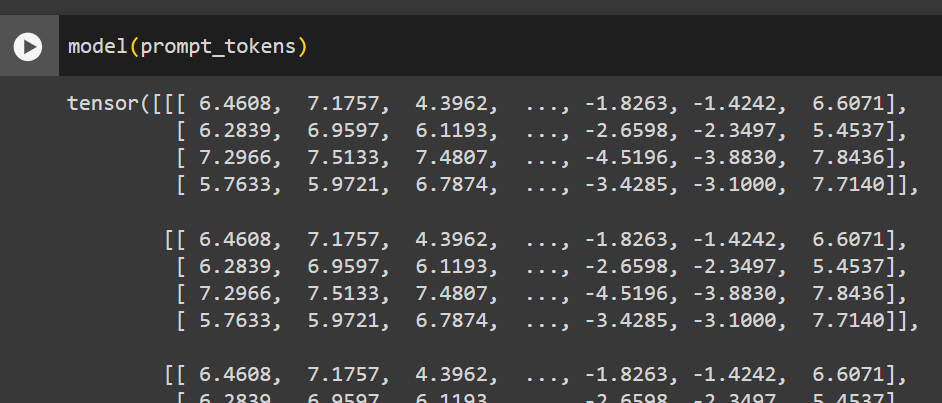

It's clearly broadcasting the same batch 1 input 100 times. So we just have to choose 1.

In [ ]:
lst = list(range(9))

CIRCUIT = {
    "number mover": lst,
    # "number mover 4": lst,
    "number mover 3": lst,
    "number mover 2": lst,
    "number mover 1": lst,
}

SEQ_POS_TO_KEEP = {
    "number mover": "end",
    # "number mover 4": "S4",
    "number mover 3": "S3",
    "number mover 2": "S2",
    "number mover 1": "S1",
}

In [ ]:
mlp_outputs_and_posns_to_keep = get_mlp_outputs_and_posns_to_keep(dataset_2, model, CIRCUIT, SEQ_POS_TO_KEEP)

In [ ]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

# Get a hook function which will patch in the mean MLP output values for each MLP layer, at
# all positions which aren't important for the circuit
hook_fn = partial(
    hook_fn_mask_mlp_out,
    mlp_outputs_and_posns_to_keep = mlp_outputs_and_posns_to_keep,
    means=means
)

# Apply hook
model.add_hook(lambda name: name.endswith("mlp_out"), hook_fn, is_permanent=True)

# new_logits = model(dataset.toks)
# # new_logits.size()

# new_score = logits_to_ave_logit_diff(new_logits, dataset)

# print(f"Average logit difference (dataset, using entire model): {orig_score:.4f}")
# print(f"Average logit difference (dataset, only using circuit): {new_score:.4f}")
# print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")

In [ ]:
# if prepend_space_to_answer and not answer.startswith(" "):
#     answer = " " + answer
# GPT-2 often treats the first token weirdly, so lets give it a resting position
prompt_tokens = model.to_tokens(prompt, prepend_bos=False)
answer_tokens = model.to_tokens(answer, prepend_bos=False)
# tokens = torch.cat((prompt_tokens, answer_tokens), dim=1)
prompt_str_tokens = model.to_str_tokens(prompt, prepend_bos=False)
answer_str_tokens = model.to_str_tokens(answer, prepend_bos=False)
prompt_length = len(prompt_str_tokens)
answer_length = len(answer_str_tokens)

print("Tokenized prompt:", prompt_str_tokens)
print("Tokenized answer:", answer_str_tokens)
logits = remove_batch_dim(model(prompt_tokens))
probs = logits.softmax(dim=-1)

Tokenized prompt: ['1', ' 2', ' 3', ' 4']
Tokenized answer: [' 5']


In [ ]:
model(prompt_tokens).size()

torch.Size([1, 4, 50257])

In [ ]:
logits.size()

torch.Size([4, 50257])

The issue here is that means dataset has batche size 100, so logits has 100. But why does this only happen after adding the hook?

In [ ]:
top_k = 6

answer_ranks = []
for index in range(prompt_length, prompt_length + answer_length):
    answer_token = tokens[0, index]
    answer_str_token = answer_str_tokens[index - prompt_length]
    # Offset by 1 because models predict the NEXT token
    token_probs = probs[index - 1]
    sorted_token_probs, sorted_token_values = token_probs.sort(descending=True) # sorted_token_values are the indices; the indices correspond to token num of vocab
    break
sorted_token_values == answer_token

tensor([False,  True, False,  ..., False, False, False])

In [ ]:
probs.size()

torch.Size([4, 50257])

In [ ]:
sorted_token_values.size()

torch.Size([50257])

In [ ]:
torch.arange(len(sorted_token_values))

tensor([    0,     1,     2,  ..., 50254, 50255, 50256])

In [ ]:
top_k = 6

answer_ranks = []
for index in range(prompt_length, prompt_length + answer_length):
    answer_token = tokens[0, index]
    answer_str_token = answer_str_tokens[index - prompt_length]
    # Offset by 1 because models predict the NEXT token
    token_probs = probs[index - 1]
    sorted_token_probs, sorted_token_values = token_probs.sort(descending=True) # sorted_token_values are the indices; the indices correspond to token num of vocab
    # Janky way to get the index of the token in the sorted list - I couldn't find a better way?
    correct_rank = torch.arange(len(sorted_token_values))[
        (sorted_token_values == answer_token).cpu()
    ].item()
    answer_ranks.append((answer_str_token, correct_rank))

    # String formatting syntax - the first number gives the number of characters to pad to, the second number gives the number of decimal places.
    # rprint gives rich text printing
    print(
        f"Performance on answer token:\n[b]Rank: {correct_rank: <8} Logit: {logits[index-1, answer_token].item():5.2f} Prob: {token_probs[answer_token].item():6.2%} Token: |{answer_str_token}|[/b]"
    )
    for i in range(top_k):
        print(
            f"Top {i}th token. Logit: {logits[index-1, sorted_token_values[i]].item():5.2f} Prob: {sorted_token_probs[i].item():6.2%} Token: |{model.to_string(sorted_token_values[i])}|"
        )
print(f"[b]Ranks of the answer tokens:[/b] {answer_ranks}")

Performance on answer token:
[b]Rank: 1        Logit: 14.38 Prob: 16.97% Token: | 5|[/b]
Top 0th token. Logit: 14.86 Prob: 27.48% Token: | 4|
Top 1th token. Logit: 14.38 Prob: 16.97% Token: | 5|
Top 2th token. Logit: 13.88 Prob: 10.32% Token: | 3|
Top 3th token. Logit: 13.54 Prob:  7.37% Token: | 6|
Top 4th token. Logit: 13.54 Prob:  7.34% Token: | 1|
Top 5th token. Logit: 13.08 Prob:  4.62% Token: | 2|
[b]Ranks of the answer tokens:[/b] [(' 5', 1)]


We see that MLP ablation of MLPs 10 and 11 messes it up so that it chooses 4, but doesn't choose 5.

# MLP and Head together

In [ ]:
def get_heads_and_posns_to_keep(
    means_dataset: Dataset,
    model: HookedTransformer,
    circuit: Dict[str, List[Tuple[int, int]]],
    seq_pos_to_keep: Dict[str, str],
) -> Dict[int, Bool[Tensor, "batch seq head"]]:
    '''
    Returns a dictionary mapping layers to a boolean mask giving the indices of the
    z output which *shouldn't* be mean-ablated.

    The output of this function will be used for the hook function that does ablation.
    '''
    heads_and_posns_to_keep = {}
    batch, seq, n_heads = len(means_dataset), means_dataset.max_len, model.cfg.n_heads

    for layer in range(model.cfg.n_layers):

        mask = t.zeros(size=(batch, seq, n_heads))

        for (head_type, head_list) in circuit.items():
            seq_pos = seq_pos_to_keep[head_type]
            indices = means_dataset.word_idx[seq_pos] # modify this for key vs query pos. curr, this is query
            for (layer_idx, head_idx) in head_list:
                if layer_idx == layer:
                    mask[:, indices, head_idx] = 1

        heads_and_posns_to_keep[layer] = mask.bool()

    return heads_and_posns_to_keep

def hook_fn_mask_z(
    z: Float[Tensor, "batch seq head d_head"],
    hook: HookPoint,
    heads_and_posns_to_keep: Dict[int, Bool[Tensor, "batch seq head"]],
    means: Float[Tensor, "layer batch seq head d_head"],
) -> Float[Tensor, "batch seq head d_head"]:
    '''
    Hook function which masks the z output of a transformer head.

    heads_and_posns_to_keep
        Dict created with the get_heads_and_posns_to_keep function. This tells
        us where to mask.

    means
        Tensor of mean z values of the means_dataset over each group of prompts
        with the same template. This tells us what values to mask with.
    '''
    # Get the mask for this layer, and add d_head=1 dimension so it broadcasts correctly
    mask_for_this_layer = heads_and_posns_to_keep[hook.layer()].unsqueeze(-1).to(z.device)

    # Set z values to the mean
    z = t.where(mask_for_this_layer, z, means[hook.layer()])

    return z

def compute_means_by_template(
    means_dataset: Dataset,
    model: HookedTransformer
) -> Float[Tensor, "layer batch seq head_idx d_head"]:
    '''
    Returns the mean of each head's output over the means dataset. This mean is
    computed separately for each group of prompts with the same template (these
    are given by means_dataset.groups).
    '''
    # Cache the outputs of every head
    _, means_cache = model.run_with_cache(
        means_dataset.toks.long(),
        return_type=None,
        names_filter=lambda name: name.endswith("z"),
    )
    # Create tensor to store means
    n_layers, n_heads, d_head = model.cfg.n_layers, model.cfg.n_heads, model.cfg.d_head
    batch, seq_len = len(means_dataset), means_dataset.max_len
    means = t.zeros(size=(n_layers, batch, seq_len, n_heads, d_head), device=model.cfg.device)

    # Get set of different templates for this data
    for layer in range(model.cfg.n_layers):
        z_for_this_layer: Float[Tensor, "batch seq head d_head"] = means_cache[utils.get_act_name("z", layer)]
        for template_group in means_dataset.groups:
            z_for_this_template = z_for_this_layer[template_group]
            z_means_for_this_template = einops.reduce(z_for_this_template, "batch seq head d_head -> seq head d_head", "mean")
            means[layer, template_group] = z_means_for_this_template

    return means

def add_mean_ablation_hook(
    model: HookedTransformer,
    means_dataset: Dataset,
    circuit: Dict[str, List[Tuple[int, int]]] = CIRCUIT,
    seq_pos_to_keep: Dict[str, str] = SEQ_POS_TO_KEEP,
    is_permanent: bool = True,
) -> HookedTransformer:
    '''
    Adds a permanent hook to the model, which ablates according to the circuit and
    seq_pos_to_keep dictionaries.

    In other words, when the model is run on ioi_dataset, every head's output will
    be replaced with the mean over means_dataset for sequences with the same template,
    except for a subset of heads and sequence positions as specified by the circuit
    and seq_pos_to_keep dicts.
    '''

    model.reset_hooks(including_permanent=True)

    # Compute the mean of each head's output on the ABC dataset, grouped by template
    means = compute_means_by_template(means_dataset, model)

    # Convert this into a boolean map
    heads_and_posns_to_keep = get_heads_and_posns_to_keep(means_dataset, model, circuit, seq_pos_to_keep)

    # Get a hook function which will patch in the mean z values for each head, at
    # all positions which aren't important for the circuit
    hook_fn = partial(
        hook_fn_mask_z,
        heads_and_posns_to_keep=heads_and_posns_to_keep,
        means=means
    )

    # Apply hook
    model.add_hook(lambda name: name.endswith("z"), hook_fn, is_permanent=is_permanent)

    return model

In [ ]:
def add_mean_ablation_hook_MLP_head(
    model: HookedTransformer,
    means_dataset: Dataset,
    heads_lst, mlp_lst,
    is_permanent: bool = True,
) -> HookedTransformer:
    CIRCUIT = {
        "number mover": heads_lst,
        "number mover 3": heads_lst,
        "number mover 2": heads_lst,
        "number mover 1": heads_lst,
    }

    SEQ_POS_TO_KEEP = {
        "number mover": "end",
        "number mover 3": "S3",
        "number mover 2": "S2",
        "number mover 1": "S1",
    }

    model.reset_hooks(including_permanent=True)

    # Compute the mean of each head's output on the ABC dataset, grouped by template
    means = compute_means_by_template(means_dataset, model)

    # Convert this into a boolean map
    heads_and_posns_to_keep = get_heads_and_posns_to_keep(means_dataset, model, CIRCUIT, SEQ_POS_TO_KEEP)

    # Get a hook function which will patch in the mean z values for each head, at
    # all positions which aren't important for the circuit
    hook_fn = partial(
        hook_fn_mask_z,
        heads_and_posns_to_keep=heads_and_posns_to_keep,
        means=means
    )

    # Apply hook
    model.add_hook(lambda name: name.endswith("z"), hook_fn, is_permanent=is_permanent)

    ########################
    CIRCUIT = {
        "number mover": mlp_lst,
        "number mover 3": mlp_lst,
        "number mover 2": mlp_lst,
        "number mover 1": mlp_lst,
    }

    SEQ_POS_TO_KEEP = {
        "number mover": "end",
        "number mover 3": "S3",
        "number mover 2": "S2",
        "number mover 1": "S1",
    }

    # Compute the mean of each head's output on the ABC dataset, grouped by template
    means = compute_means_by_template_MLP(means_dataset, model)

    # Convert this into a boolean map
    mlp_outputs_and_posns_to_keep = get_mlp_outputs_and_posns_to_keep(means_dataset, model, CIRCUIT, SEQ_POS_TO_KEEP)

    # Get a hook function which will patch in the mean z values for each head, at
    # all positions which aren't important for the circuit
    hook_fn = partial(
        hook_fn_mask_mlp_out,
        mlp_outputs_and_posns_to_keep=mlp_outputs_and_posns_to_keep,
        means=means
    )

    # Apply hook
    model.add_hook(lambda name: name.endswith("mlp_out"), hook_fn, is_permanent=True)

    return model

In [ ]:
heads_not_ablate = [(layer, head) for layer in range(12) for head in range(12)]
mlps_not_ablate = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)
new_logits = model(dataset.toks)
new_score = logits_to_ave_logit_diff(new_logits, dataset)
print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")

Average logit difference (circuit / full) %: 100.0000


In [ ]:
# get rid of last layer

heads_not_ablate = [(layer, head) for layer in range(11) for head in range(12)]
mlps_not_ablate = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)
new_logits = model(dataset.toks)
new_score = logits_to_ave_logit_diff(new_logits, dataset)
print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")

Average logit difference (circuit / full) %: 74.3485


In [ ]:
# get rid of heads in L11

heads_not_ablate = [(layer, head) for layer in range(11) for head in range(12)]
mlps_not_ablate = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)
new_logits = model(dataset.toks)
new_score = logits_to_ave_logit_diff(new_logits, dataset)
print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")

Average logit difference (circuit / full) %: 99.3207


Try ablating by orig dataset mean

In [ ]:
# get rid of heads in L11

heads_not_ablate = [(layer, head) for layer in range(10) for head in range(10)]
mlps_not_ablate = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

model = add_mean_ablation_hook_MLP_head(model, dataset, heads_not_ablate, mlps_not_ablate)
new_logits = model(dataset.toks)
new_score = logits_to_ave_logit_diff(new_logits, dataset)
print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")

Average logit difference (circuit / full) %: 30.9183


# Head Ablation Expm Functions

In [ ]:
# model.reset_hooks(including_permanent=True)
# ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)
# orig_score = logits_to_ave_logit_diff(ioi_logits_original, dataset)

In [ ]:
def mean_ablate_by_lst(lst, model, orig_score, print_output=True):
    CIRCUIT = {
        "number mover": lst,
        # "number mover 4": lst,
        "number mover 3": lst,
        "number mover 2": lst,
        "number mover 1": lst,
    }

    SEQ_POS_TO_KEEP = {
        "number mover": "end",
        # "number mover 4": "S4",
        "number mover 3": "S3",
        "number mover 2": "S2",
        "number mover 1": "S1",
    }

    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

    # ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

    model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
    ioi_logits_minimal = model(dataset.toks)

    # orig_score = logits_to_ave_logit_diff_2(ioi_logits_original, dataset)
    new_score = logits_to_ave_logit_diff(ioi_logits_minimal, dataset)
    if print_output:
        # print(f"Average logit difference (IOI dataset, using entire model): {orig_score:.4f}")
        # print(f"Average logit difference (IOI dataset, only using circuit): {new_score:.4f}")
        print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")
    # return new_score
    return 100 * new_score / orig_score

In [ ]:
def find_circuit_forw(curr_circuit=None, orig_score=100, threshold=10):
    # threshold is T, a %. if performance is less than T%, allow its removal
    if curr_circuit == []:
        # Start with full circuit
        curr_circuit = [(layer, head) for layer in range(12) for head in range(12)]

    for layer in range(0, 12):
        for head in range(12):
            if (layer, head) not in curr_circuit:
                continue

            # Copying the curr_circuit so we can iterate over one and modify the other
            copy_circuit = curr_circuit.copy()

            # Temporarily removing the current tuple from the copied circuit
            copy_circuit.remove((layer, head))

            new_score = mean_ablate_by_lst(copy_circuit, model, orig_score, print_output=False).item()

            # print((layer,head), new_score)
            # If the result is less than the threshold, remove the tuple from the original list
            if (100 - new_score) < threshold:
                curr_circuit.remove((layer, head))

                print("\nRemoved:", (layer, head))
                print(new_score)

    return curr_circuit, new_score

In [ ]:
def find_circuit_backw(curr_circuit=None, orig_score=100, threshold=10):
    # threshold is T, a %. if performance is less than T%, allow its removal
    if curr_circuit == []:
        # Start with full circuit
        curr_circuit = [(layer, head) for layer in range(12) for head in range(12)]

    for layer in range(11, -1, -1):  # go thru all heads in a layer first
        for head in range(12):
            if (layer, head) not in curr_circuit:
                continue

            # Copying the curr_circuit so we can iterate over one and modify the other
            copy_circuit = curr_circuit.copy()

            # Temporarily removing the current tuple from the copied circuit
            copy_circuit.remove((layer, head))

            new_score = mean_ablate_by_lst(copy_circuit, model, orig_score, print_output=False).item()

            # If the result is less than the threshold, remove the tuple from the original list
            if (100 - new_score) < threshold:
                curr_circuit.remove((layer, head))

                print("\nRemoved:", (layer, head))
                print(new_score)

    return curr_circuit, new_score